<a href="https://colab.research.google.com/github/ShauryaBhardwaj/PASTIS/blob/main/UTAE_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset and source code

In [1]:
!git clone https://github.com/VSainteuf/pastis-benchmark.git
!git clone https://github.com/VSainteuf/utae-paps.git
!wget https://zenodo.org/records/5012942/files/PASTIS.zip
!unzip PASTIS.zip

Streaming output truncated to the last 5000 lines.
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_30638.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_20403.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_10477.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_20007.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_10150.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/HEATMAP_40229.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_10385.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_40227.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_40175.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_30336.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_20047.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_30072.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/INSTANCES_20325.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_40152.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIONS/ZONES_40146.npy  
  inflating: PASTIS/INSTANCE_ANNOTATIO

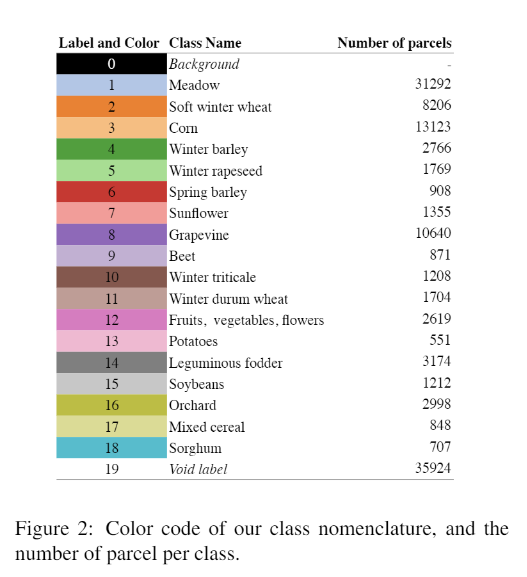

# EDA and Feature Selection

Code block for EDA. To select images with the most information.
Here we will strive to ~one third of the images.
Image selection will be based on the following -
1. number of different parcels in the image
2. Which parcels are present (i.e. select rarer parcels and select lesser of abundant parcels)

We will save this dataset to Google drive so it is easier to access it when it is loaded again.

In [ ]:
endangered_classes = [13,9,6,7,10,15,17,18] #these must definitely be chosen
priority_list = [] #order the classes based on their occurences and calculate the score of each image. sort images on the basis of this score and take the top p percentile of the data.
evaluation_of_selected_subset = [] #use some metric to check the distribution of the selected images

# Data Loading and Visualisations

In [7]:
PATH_TO_CODE = '/pastis-benchmark/code/'
PATH_TO_PASTIS = '../../PASTIS'

import sys
sys.path.append(PATH_TO_CODE)


import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib

cm = matplotlib.cm.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,20)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=21)

def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image
    from a Sentinel-2 time series.
    """
    im = x['S2'][batch_index, t_show, [2,1,0]].cpu().numpy()
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

<ipython-input-7-15e332db8289>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = matplotlib.cm.get_cmap('tab20')


In [21]:
from dataloader import PASTIS_Dataset
from collate import pad_collate

dt = PASTIS_Dataset(PATH_TO_PASTIS, norm=True, target='instance')
dl = torch.utils.data.DataLoader(dt, batch_size=5, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .


/content/pastis-benchmark/code/dataloader.py:119: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, date_seq in dates.iteritems():


Done.
Dataset ready.


In [29]:
(x, dates), y = dl.__iter__().__next__()

print(x['S2'].shape)
print(dates['S2'].shape)

torch.Size([5, 61, 10, 128, 128])
torch.Size([5, 61])


## Improve this Visualisation code
Anyway this is not applicable for semantic segmentation

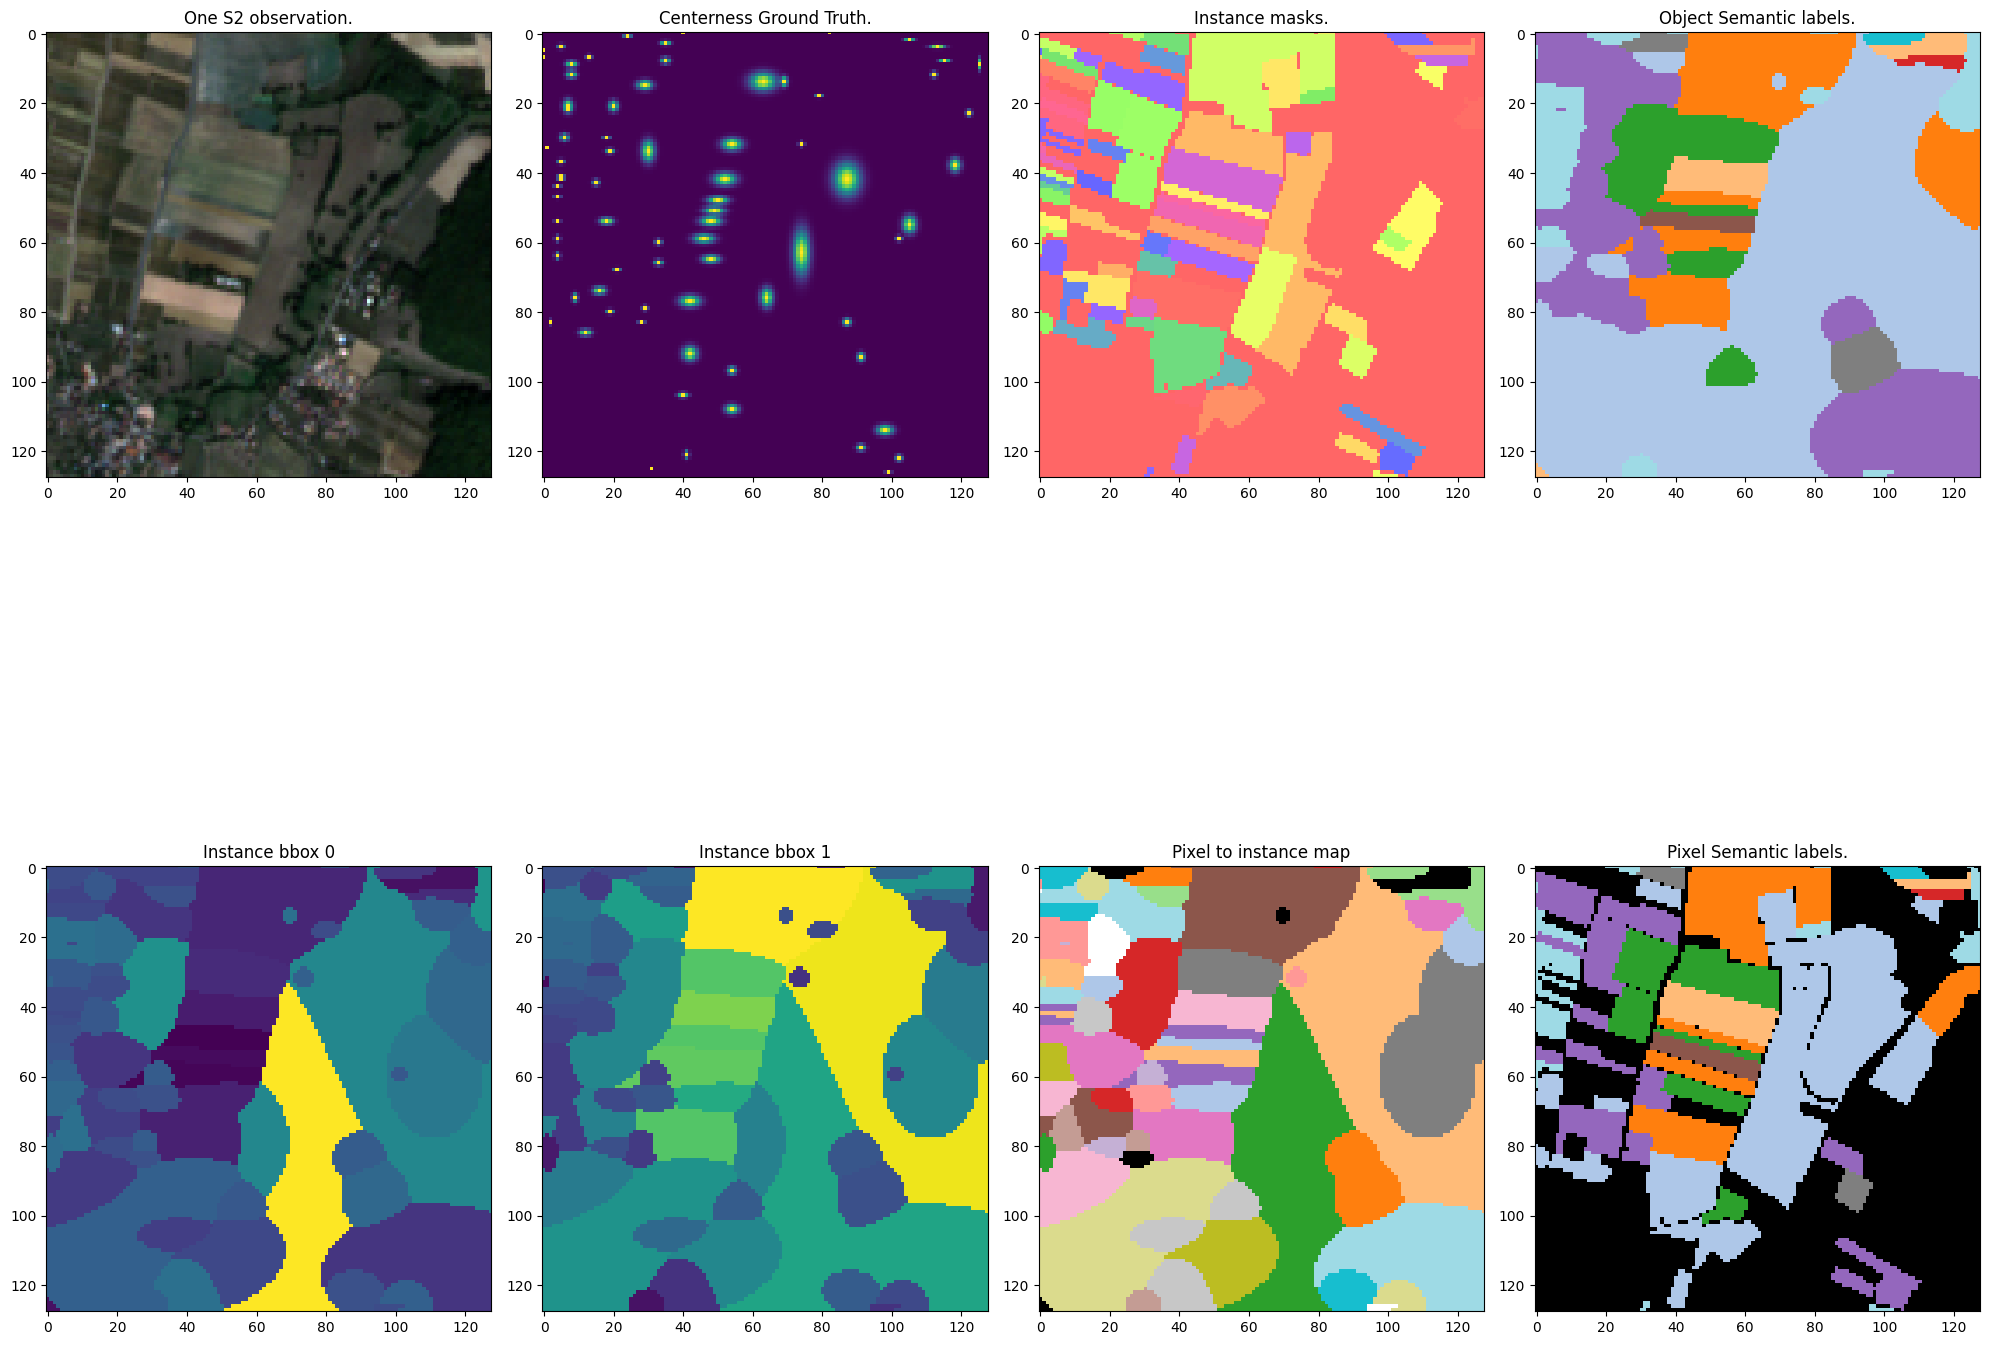

In [ ]:
bid = 0

fix, axes = plt.subplots(2,4, figsize=(20,20))

axes[0][0].imshow(get_rgb(x, batch_index=bid))
axes[0][1].imshow(target_heatmap[bid].squeeze())
axes[0][2].imshow(instance_ids[bid].squeeze(), cmap='prism', alpha=.6)
axes[0][3].imshow(object_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[1][0].imshow(instance_bbox_size[bid , : , : , 0].squeeze()-instance_bbox_size[bid , : , : , 1].squeeze())
axes[1][1].imshow(instance_bbox_size[bid , : , : , 1].squeeze())
axes[1][2].imshow(pixel_to_instance_mapping[bid].squeeze(), cmap=cmap)
axes[1][3].imshow(pixel_semantic_annotation[bid].squeeze(), cmap=cmap, vmin=0, vmax=20)

axes[0][0].set_title('One S2 observation.')
axes[0][1].set_title('Centerness Ground Truth.')
axes[0][2].set_title('Instance masks.')
axes[0][3].set_title('Object Semantic labels.')

axes[1][0].set_title('Instance bbox 0')
axes[1][1].set_title('Instance bbox 1')
axes[1][2].set_title('Pixel to instance map')
axes[1][3].set_title('Pixel Semantic labels.')

plt.tight_layout()
plt.show()

# UTAE Model

In [ ]:
import torch
import torch.nn as nn

class UTAE(nn.Module):
  def __init__(
      self,
      input_channels,
      encoder_widths = [64,64,64,128],
      decoder_widths = [32,32,64,128],
      out_conv=[32,20],
      kernel_size=4,
      stride_length=2,
      padding=1,
      agg_mode="att_group",
      encoder_norm="group",
      n_head=16,
      d_model=256,
      d_k=4,
      encoder=False,
      return_maps=False,
      pad_value=0,
      padding_mode="reflect"):

    super(UTAE, self).__init__()
    self.n_stages = len(encoder_widths)
    self.return_maps = return_maps
    self.encoder_widths = encoder_widths
    self.decoder_widths = decoder_widths
    self.pad_value = pad_value
    self.encoder = encoder


    self.in_conv = ConvBlock(
        nkernels=[input_channels]+[encoder_widths[0] , encoder_widths[0]],
        pad_value = pad_value,
        norm = encoder_norm,
        padding_mode=padding_mode
    )

    self.down_blocks = nn.ModuleList(
        DownConvBlock(
            d_in = encoder_widths[i],
            d_out = encoder_widths[i+1],
            k=kernel_size,
            s=stride_length,
            p=padding,
            pad_value=pad_value,
            norm=encoder_norm,
            padding_mode = padding_mode
        )
        for i in range(self.n_stages-1)
    )

    self.up_blocks = nn.ModuleList(
        UpConvBlock(
            d_in = decoder_widths[i],
            d_out = decoder_widths[i-1],
            d_skip = encoder_widths[i-1],
            k = kernel_size,
            s=stride_length,
            p=padding,
            norm="batch",
            padding_mode=padding_mode
        )
        for i in range(self.n_stages-1 , 0 , -1)
    )

    self.temporal_encoder = LTAE2d(
        in_channels = encoder_widths[-1],
        d_model=d_model,
        n_head=n_head,
        mlp=[d_model,encoder_widths[-1]],
        return_att=True,
        d_k=d_k
    )

    self.temporal_aggregator = Temporal_Aggregator(mode=agg_mode)
    self.out_conv = ConvBlock(nkernels=[decoder_widths[0]]+out_conv , padding_mode=padding_mode)

  def forward(self , input , batch_positions=None , return_att=False):

    pad_mask = (
        (input == self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
    )
    out = self.in_conv.smart_forward(input)
    feature_maps = [out]

    #Spatial Encoder

    for i in range(self.n_stages - 1):
      out = self.down_blocks[i].smart_forward(feature_maps[-1])
      feature_maps.append(out)

    #Temporal Encoder
    out , att = self.temporal_encoder(
        feature_maps[-1] , batch_positions=batch_positions , pad_mask=pad_mask)

    #Spatial Decoder
    if(self.return_maps):
      maps = [out]

    for i in range(self.n_stages - 1):
      skip = self.temporal_aggregator(
          feature_maps[-(i+2)] , pad_mask=pad_mask , attn_mask=att)
      out = self.up_blocks[i](out , skip)
      if(self.return_maps):
        maps.append(out)

    if(self.encoder):
      return out,maps

    else:
      out = self.out_conv(out)
      if(return_att):
        return out,att
      if(self.return_maps):
        return out,maps
      else:
        return out

In [6]:
class TemporallySharedBlock(nn.Module):
  def __init__(self , pad_value=None):
    super(TemporallySharedBlock , self).__init__()
    self.out_shape=None
    self.pad_value=pad_value

  def smart_forward(self, input):

    if(len(input.shape) == 4):
      return self.forward(input)

    else:
      b,t,c,h,w = input.shape

      if(self.pad_value is not None):
        dummy = torch.zeros(input.shape , device=input.device).float()
        self.out_shape = self.forward(dummy.view(b*t,c,h,w)).shape

      out = input.view(b*t , c , h , w)

      if(self.pad_value is not None):
        pad_mask = (out==self.pad_value).all(dim=-1).all(dim=-1).all(dim=-1)
        if(pad_mask.any()):
          temp = (
              torch.ones(
                  self.out_shape , device=input.device , requires_grad=False
              ) * self.pad_value
          )

          temp[~pad_mask] = self.forward(out[~pad_mask])
          out = temp

        else:
          out = self.forward(out)

      else:
        out = self.forward(out)

    _ , c , h , w = out.shape
    out = out.view(b,t,c,h,w)

    return out


In [7]:
class ConvLayer(nn.Module):
  def __init__(
      self,
      nkernels,
      norm="batch",
      k=3,
      s=1,
      p=1,
      n_groups=4,
      last_relu=True,
      padding_mode="reflect"):

    super(ConvLayer , self).__init__()
    layers=[]

    if(norm == "batch"):
      n1 = nn.BatchNorm2d
    elif(norm == "instance"):
      n1 = nn.InstanceNorm2d
    elif(norm == "group"):
      n1 = lambda num_feats: nn.GroupNorm(num_channels=num_feats,num_groups=n_groups)
    else:
      n1 = None


    for i in range(len(nkernels) - 1 ):
      layers.append(
          nn.Conv2d(
              in_channels = nkernels[i],
              out_channels = nkernels[i+1],
              kernel_size=k,
              padding=p,
              stride=s,
              padding_mode=padding_mode
          )
      )

      if(n1 is not None):
        layers.append(n1(nkernels[i+1]))

      if(last_relu):
        layers.append(nn.ReLU())

      elif(i< (len(nkernels)-2)):
        layers.append(nn.ReLU())

    self.conv = nn.Sequential(*layers)

  def forward(self , input):
    return self.conv(input)

In [8]:
class ConvBlock(TemporallySharedBlock):
  def __init__(
      self,
      nkernels,
      pad_value=None,
      norm="batch",
      last_relu=True,
      padding_mode="reflect"):

    super(ConvBlock,self).__init__(pad_value=pad_value)
    self.conv = ConvLayer(
        nkernels=nkernels,
        norm=norm,
        last_relu=last_relu,
        padding_mode=padding_mode
    )

  def forward(self , input):
    return self.conv(input)

In [9]:
class DownConvBlock(TemporallySharedBlock):
  def __init__(
      self,
      d_in,
      d_out,
      k,
      s,
      p,
      pad_value=None,
      norm="batch",
      padding_mode="reflect"):

    super(DownConvBlock , self).__init__(pad_value = pad_value)
    self.down = ConvLayer(
        nkernels=[d_in , d_in],
        norm = norm,
        k=k,
        s=s,
        p=p,
        padding_mode=padding_mode
    )

    self.conv1 = ConvLayer(
        nkernels=[d_in,d_out],
        norm=norm,
        padding_mode=padding_mode
    )

    self.conv2 = ConvLayer(
        nkernels=[d_out , d_out],
        norm=norm,
        padding_mode=padding_mode
    )

  def forward(self , input):
    out = self.down(input)
    out = self.conv1(out)
    out = out + self.conv2(out)

    return out

In [10]:
class UpConvBlock(nn.Module):
  def __init__(self,
               d_in,
               d_out,
               k,
               s,
               p,
               norm="batch",
               d_skip=None,
               padding_mode="reflect"):
    super(UpConvBlock , self).__init__()

    d = d_out if d_skip is None else d_skip
    self.skip_conv = nn.Sequential(
        nn.Conv2d(in_channels=d , out_channels=d , kernel_size=1),
        nn.BatchNorm2d(d),
        nn.ReLU()
    )

    self.up = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels=d_in,
            out_channels=d_out,
            kernel_size=k,
            stride=s,
            padding=p
        ),
        nn.BatchNorm2d(d_out),
        nn.ReLU()
    )

    self.conv1 = ConvLayer(
        nkernels=[d_out+d,d_out],
        norm=norm,
        padding_mode=padding_mode
    )

    self.conv2 = ConvLayer(
        nkernels=[d_out,d_out],
        norm=norm,
        padding_mode=padding_mode
    )

  def forward(self , input , skip):

    out = self.up(input)
    out = torch.cat([out , self.skip_conv(skip)] , dim=1)
    out = self.conv1(out)
    out = out + self.conv2(out)

    return out


In [11]:
class Temporal_Aggregator(nn.Module):
  def __init__(self , mode="mean"):
    super(Temporal_Aggregator , self).__init__()
    self.mode = mode

  def forward(self , x , pad_mask=None , attn_mask=None):
    if(pad_mask is not None and pad_mask.any()):
      if(self.mode == "att_group"):
        n_heads , b , t , h , w = attn_mask.shape
        attn = attn_mask.view(n_heads*b,t,h,w)

      if(x.shape[-2] > w):
        attn = nn.Upsample(
            size=x.shape[-2:] , mode="bilinear" , align_corners=False
        )(attn)

      else:
        attn.nn.AvgPool2d(kernel_size= (w//x.shape[-2]))(attn)

      attn = attn.view(n_heads , b , t , *x.shape[-2:])
      attn = attn * (~pad_mask).float()[None,:,:,None,None]

      out = torch.stack(x.chunk(n_heads , dim=2))
      out = attn[:,:,:,None,:,:]*out
      out = out.sum(dim=2)
      out = torch.cat([group for group in out] , dim = 1)
      return out

    elif self.mode == "att_mean":
      attn = attn_mask.mean(dim=0)
      attn = nn.Upsample(
          size=x.shape[-2:] , mode="bilinear" , align_corners=False
      )(attn)
      attn = attn * (~pad_mask).float()[:,:,None,None]
      out = (x*attn[:,:,None,:,:]).sum(dim=1)
      return out

    elif self.mode == "mean":
      out = x*(~pad_mask).float()[:,:,None,None]
      out = out.sum(dim=1)/(~pad_mask).sum(dim=1)[:,None,None,None,None]
      return out

    else:
      if(self.mode=="att_group"):
        n_heads , b , t, h,w = attn_mask.shape
        attn = attn_mask.view(n_heads*b , t , h , w)
        if(x.shape[-2]>w):
          attn = nn.Upsample(
              size=x.shape[-2:] , mode="bilinear" , align_corners=False
          )(attn)
        else:
          attn = nn.AvgPool2d(kernel_size=w//x.shape[-2])(attn)

        attn = attn.view(n_heads , b , t , *x.shape[-2:])
        out = torch.stack(x.chunk(n_heads,dim=2))
        out = attn[:,:,:,None,:,:]*out
        out = out.sum(dim=2)
        out = torch.cat([group for group in out] , dim=1)
        return out

      elif self.mode == "att_mean":
        attn = attn_mask.mean(dim=0)
        attn = nn.Upsample(
            size=x.shape[-2,:],mode="bilinear",align_corners=False
        )(attn)
        out = (x*attn[:,:,None,:,:]).sum(dim=1)
        return out

      elif self.mode == "mean":
        return x.mean(dim=1)

In [12]:
import torch
import torch.nn as nn


class PositionalEncoder(nn.Module):
    def __init__(self, d, T=1000, repeat=None, offset=0):
        super(PositionalEncoder, self).__init__()
        self.d = d
        self.T = T
        self.repeat = repeat
        self.denom = torch.pow(
            T, 2 * (torch.arange(offset, offset + d).float() // 2) / d
        )
        self.updated_location = False

    def forward(self, batch_positions):
        if not self.updated_location:
            self.denom = self.denom.to(batch_positions.device)
            self.updated_location = True
        sinusoid_table = (
            batch_positions[:, :, None] / self.denom[None, None, :]
        )  # B x T x C
        sinusoid_table[:, :, 0::2] = torch.sin(sinusoid_table[:, :, 0::2])  # dim 2i
        sinusoid_table[:, :, 1::2] = torch.cos(sinusoid_table[:, :, 1::2])  # dim 2i+1

        if self.repeat is not None:
            sinusoid_table = torch.cat(
                [sinusoid_table for _ in range(self.repeat)], dim=-1
            )

        return sinusoid_table

In [13]:
import copy

import numpy as np
import torch
import torch.nn as nn

class LTAE2d(nn.Module):
    def __init__(
        self,
        in_channels=128,
        n_head=16,
        d_k=4,
        mlp=[256, 128],
        dropout=0.2,
        d_model=256,
        T=1000,
        return_att=False,
        positional_encoding=True,
    ):
        """
        Lightweight Temporal Attention Encoder (L-TAE) for image time series.
        Attention-based sequence encoding that maps a sequence of images to a single feature map.
        A shared L-TAE is applied to all pixel positions of the image sequence.
        Args:
            in_channels (int): Number of channels of the input embeddings.
            n_head (int): Number of attention heads.
            d_k (int): Dimension of the key and query vectors.
            mlp (List[int]): Widths of the layers of the MLP that processes the concatenated outputs of the attention heads.
            dropout (float): dropout
            d_model (int, optional): If specified, the input tensors will first processed by a fully connected layer
                to project them into a feature space of dimension d_model.
            T (int): Period to use for the positional encoding.
            return_att (bool): If true, the module returns the attention masks along with the embeddings (default False)
            positional_encoding (bool): If False, no positional encoding is used (default True).
        """
        super(LTAE2d, self).__init__()
        self.in_channels = in_channels
        self.mlp = copy.deepcopy(mlp)
        self.return_att = return_att
        self.n_head = n_head

        if d_model is not None:
            self.d_model = d_model
            self.inconv = nn.Conv1d(in_channels, d_model, 1)
        else:
            self.d_model = in_channels
            self.inconv = None
        assert self.mlp[0] == self.d_model

        if positional_encoding:
            self.positional_encoder = PositionalEncoder(
                self.d_model // n_head, T=T, repeat=n_head
            )
        else:
            self.positional_encoder = None

        self.attention_heads = MultiHeadAttention(
            n_head=n_head, d_k=d_k, d_in=self.d_model
        )
        self.in_norm = nn.GroupNorm(
            num_groups=n_head,
            num_channels=self.in_channels,
        )
        self.out_norm = nn.GroupNorm(
            num_groups=n_head,
            num_channels=mlp[-1],
        )

        layers = []
        for i in range(len(self.mlp) - 1):
            layers.extend(
                [
                    nn.Linear(self.mlp[i], self.mlp[i + 1]),
                    nn.BatchNorm1d(self.mlp[i + 1]),
                    nn.ReLU(),
                ]
            )

        self.mlp = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, batch_positions=None, pad_mask=None, return_comp=False):
        sz_b, seq_len, d, h, w = x.shape
        if pad_mask is not None:
            pad_mask = (
                pad_mask.unsqueeze(-1)
                .repeat((1, 1, h))
                .unsqueeze(-1)
                .repeat((1, 1, 1, w))
            )  # BxTxHxW
            pad_mask = (
                pad_mask.permute(0, 2, 3, 1).contiguous().view(sz_b * h * w, seq_len)
            )

        out = x.permute(0, 3, 4, 1, 2).contiguous().view(sz_b * h * w, seq_len, d)
        out = self.in_norm(out.permute(0, 2, 1)).permute(0, 2, 1)

        if self.inconv is not None:
            out = self.inconv(out.permute(0, 2, 1)).permute(0, 2, 1)

        if self.positional_encoder is not None:
            bp = (
                batch_positions.unsqueeze(-1)
                .repeat((1, 1, h))
                .unsqueeze(-1)
                .repeat((1, 1, 1, w))
            )  # BxTxHxW
            bp = bp.permute(0, 2, 3, 1).contiguous().view(sz_b * h * w, seq_len)
            out = out + self.positional_encoder(bp)

        out, attn = self.attention_heads(out, pad_mask=pad_mask)

        out = (
            out.permute(1, 0, 2).contiguous().view(sz_b * h * w, -1)
        )  # Concatenate heads
        out = self.dropout(self.mlp(out))
        out = self.out_norm(out) if self.out_norm is not None else out
        out = out.view(sz_b, h, w, -1).permute(0, 3, 1, 2)

        attn = attn.view(self.n_head, sz_b, h, w, seq_len).permute(
            0, 1, 4, 2, 3
        )  # head x b x t x h x w

        if self.return_att:
            return out, attn
        else:
            return out


In [14]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention module
    Modified from github.com/jadore801120/attention-is-all-you-need-pytorch
    """

    def __init__(self, n_head, d_k, d_in):
        super().__init__()
        self.n_head = n_head
        self.d_k = d_k
        self.d_in = d_in

        self.Q = nn.Parameter(torch.zeros((n_head, d_k))).requires_grad_(True)
        nn.init.normal_(self.Q, mean=0, std=np.sqrt(2.0 / (d_k)))

        self.fc1_k = nn.Linear(d_in, n_head * d_k)
        nn.init.normal_(self.fc1_k.weight, mean=0, std=np.sqrt(2.0 / (d_k)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))

    def forward(self, v, pad_mask=None, return_comp=False):
        d_k, d_in, n_head = self.d_k, self.d_in, self.n_head
        sz_b, seq_len, _ = v.size()

        q = torch.stack([self.Q for _ in range(sz_b)], dim=1).view(
            -1, d_k
        )  # (n*b) x d_k

        k = self.fc1_k(v).view(sz_b, seq_len, n_head, d_k)
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, seq_len, d_k)  # (n*b) x lk x dk

        if pad_mask is not None:
            pad_mask = pad_mask.repeat(
                (n_head, 1)
            )  # replicate pad_mask for each head (nxb) x lk

        v = torch.stack(v.split(v.shape[-1] // n_head, dim=-1)).view(
            n_head * sz_b, seq_len, -1
        )
        if return_comp:
            output, attn, comp = self.attention(
                q, k, v, pad_mask=pad_mask, return_comp=return_comp
            )
        else:
            output, attn = self.attention(
                q, k, v, pad_mask=pad_mask, return_comp=return_comp
            )
        attn = attn.view(n_head, sz_b, 1, seq_len)
        attn = attn.squeeze(dim=2)

        output = output.view(n_head, sz_b, 1, d_in // n_head)
        output = output.squeeze(dim=2)

        if return_comp:
            return output, attn, comp
        else:
            return output, attn


class ScaledDotProductAttention(nn.Module):
    """Scaled Dot-Product Attention
    Modified from github.com/jadore801120/attention-is-all-you-need-pytorch
    """

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, pad_mask=None, return_comp=False):
        attn = torch.matmul(q.unsqueeze(1), k.transpose(1, 2))
        attn = attn / self.temperature
        if pad_mask is not None:
            attn = attn.masked_fill(pad_mask.unsqueeze(1), -1e3)
        if return_comp:
            comp = attn
        # compat = attn
        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)

        if return_comp:
            return output, attn, comp
        else:
            return output, attn

# Helper functions

In [17]:
!pip install torchnet
%cd pastis-benchmark/code
!wget https://zenodo.org/records/5172293/files/UTAE_SemanticSeg_weights.zip
!unzip UTAE_SemanticSeg_weights.zip

  Using cached torchnet-0.0.4.tar.gz (23 kB)
  Preparing metadata (setup.py) ... done
  Using cached visdom-0.2.4.tar.gz (1.4 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29729 sha256=64c2a5d21b748ae38c7a3ae0f1a24e37e923e41c9c02441f418075ba1246dd03
  Stored in directory: /root/.cache/pip/wheels/f7/ae/94/9f5edd6871983f30967ad11d60ef434c3d1b007654de4c8065
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=b68f742fd5d65a86bf7426396ab524b5922107a56c3a66d95214b9c12fef107f
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built torchnet visdom


In [18]:
import torchnet as tnt
import time
from collate import pad_collate
from dataloader import PASTIS_Dataset
import torch.utils.data as data
import os

In [19]:
def recursive_todevice(x , device):
  if isinstance(x , torch.Tensor):
    return x.to(device)
  elif (isinstance(x , dict)):
    return {k:recursive_todevice(v,device) for k,v in x.items()}
  else:
    return [recursive_todevice(c , device) for c in x]

In [20]:
import numpy as np
import torch


class Metric(object):
    def reset(self):
        pass
    def add(self):
        pass
    def value(self):
        pass

class ConfusionMatrix(Metric):

    def __init__(self, num_classes, normalized=False, device="cpu"):
        super().__init__()

        if(device == "cpu"):
            self.conf = np.ndarray((num_classes, num_classes), dtype=np.int64)
        else:
            self.conf = torch.zeros((num_classes, num_classes)).cuda()

        self.normalized = normalized
        self.num_classes = num_classes
        self.device = device
        self.reset()

    def reset(self):
        if self.device == 'cpu':
            self.conf.fill(0)
        else:
            self.conf = torch.zeros(self.conf.shape).cuda()

    def add(self, predicted, target):

        if self.device == 'cpu':
            if torch.is_tensor(predicted):
                predicted = predicted.cpu().numpy()
            if torch.is_tensor(target):
                target = target.cpu().numpy()

        x = predicted + self.num_classes * target

        if self.device == 'cpu':
            bincount_2d = np.bincount(
                x.astype(np.int64), minlength=self.num_classes ** 2)
            conf = bincount_2d.reshape((self.num_classes, self.num_classes))
        else:
            bincount_2d = torch.bincount(
                x, minlength=self.num_classes ** 2)

            conf = bincount_2d.view((self.num_classes, self.num_classes))
        self.conf += conf

    def value(self):
        if self.normalized:
            conf = self.conf.astype(np.float32)
            return conf / conf.sum(1).clip(min=1e-12)[:, None]
        else:
            return self.conf


class IoU(Metric):

    def __init__(self, num_classes, normalized=False, ignore_index=None, cm_device="cpu"):
        super().__init__()
        self.conf_metric = ConfusionMatrix(num_classes, normalized, device=cm_device)
        if ignore_index is None:
            self.ignore_index = None
        elif isinstance(ignore_index, int):
            self.ignore_index = (ignore_index,)

    def reset(self):
        self.conf_metric.reset()

    def add(self, predicted, target):

        if predicted.dim() == 4:
            _, predicted = predicted.max(1)
        if target.dim() == 4:
            _, target = target.max(1)

        self.conf_metric.add(predicted.view(-1), target.view(-1))

    def value(self):

        conf_matrix = self.conf_metric.value()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)

        return iou, np.nanmean(iou)

    def get_miou_acc(self):
        conf_matrix = self.conf_metric.value()
        if torch.is_tensor(conf_matrix):
            conf_matrix = conf_matrix.cpu().numpy()
        if self.ignore_index is not None:
            conf_matrix[:, self.ignore_index] = 0
            conf_matrix[self.ignore_index, :] = 0
        true_positive = np.diag(conf_matrix)
        false_positive = np.sum(conf_matrix, 0) - true_positive
        false_negative = np.sum(conf_matrix, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error
        with np.errstate(divide='ignore', invalid='ignore'):
            iou = true_positive / (true_positive + false_positive + false_negative)
        miou = float(np.nanmean(iou) * 100)
        acc = float(np.diag(conf_matrix).sum() / conf_matrix.sum() * 100)

        return miou, acc

In [21]:
def iterate(model , data_loader , criterion , optimizer = None , mode="train" , device="cpu"):

  display_step = 5
  loss_meter = tnt.meter.AverageValueMeter()
  iou_meter = IoU(num_classes=20,ignore_index=0,cm_device=device)
  t_start = time.time()

  for i, batch in enumerate(data_loader):
    if(device is not None):
      batch = recursive_todevice(batch , device)
    (x,dates) , y = batch
    y=y.long()

    if(mode!="train"):
      with torch.no_grad():
        out = model(x["S2"],batch_positions=dates["S2"])

    else:
      optimizer.zero_grad()
      out = model(x["S2"],batch_positions=dates["S2"])

    loss = criterion(out , y)
    if(mode=="train"):
      loss.backward()
      optimizer.step()

    with torch.no_grad():
      pred = out.argmax(dim=1)
      print(torch.unique(pred))
      #print(torch.unique(y[]))

    iou_meter.add(pred,y)
    loss_meter.add(loss.item())

    if(i+1)%display_step == 0:
      miou , acc = iou_meter.get_miou_acc()
      print(
          "Step [{}/{}] , Loss: {:.4f}, Acc: {:.2f} , mIoU: {:.2f}".format(i+1 , len(data_loader) , loss_meter.value()[0] , acc , miou)
      )

  t_end = time.time()
  total_time = t_end - t_start
  miou, acc = iou_meter.get_miou_acc()
  metrics = {
  "{}_accuracy".format(mode): acc,
  "{}_loss".format(mode): loss_meter.value()[0],
  "{}_IoU".format(mode): miou,
  "{}_epoch_time".format(mode): total_time
  }
  print("accuracy: " , acc)
  print("miou: " , miou)

  if(mode == "test"):
    return metrics , iou_meter.conf_metric.value()
  else:
    return metrics

# Train

In [22]:
dt_train = PASTIS_Dataset("../../PASTIS", folds=[1,2,3] , target="semantic")
dt_val = PASTIS_Dataset("../../PASTIS", folds=[4], target="semantic")
dt_test = PASTIS_Dataset("../../PASTIS", folds=[5] , target="semantic")

train_loader = data.DataLoader(dt_train , batch_size=2, collate_fn=pad_collate, shuffle=True)
val_loader = data.DataLoader(dt_train , batch_size=2, collate_fn=pad_collate, shuffle=True)
test_loader = data.DataLoader(dt_train , batch_size=2, collate_fn=pad_collate, shuffle=True)

Reading patch metadata . . .


/content/pastis-benchmark/code/dataloader.py:119: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, date_seq in dates.iteritems():


Done.
Dataset ready.
Reading patch metadata . . .


/content/pastis-benchmark/code/dataloader.py:119: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, date_seq in dates.iteritems():


Done.
Dataset ready.
Reading patch metadata . . .


/content/pastis-benchmark/code/dataloader.py:119: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for pid, date_seq in dates.iteritems():


Done.
Dataset ready.


In [27]:
model = UTAE(10)
device = ("cuda" if torch.cuda.is_available() else "cpu")
# print(len(temp_list))
# for n,p in model.named_parameters():
#   if(p.requires_grad):
#     print(n)
model = model.to(device)
sd = torch.load(
          os.path.join("UATE_zenodo/", "Fold_1", "model.pth.tar"),
          map_location="cpu",
      )
ignore_index = 0
num_classes = 20
lr=0.001
epochs = 10

model.load_state_dict(sd["state_dict"])
optimizer = torch.optim.Adam(model.parameters() , lr=lr)

weights = torch.ones(num_classes , device="cpu").float()
weights[ignore_index] = 0
criterion = nn.CrossEntropyLoss(weight=weights)

for epoch in range(1,epochs+1):
  model.train()
  iterate_op = iterate(
      model,
      data_loader = train_loader,
      criterion = criterion,
      optimizer = optimizer,
      mode="train",
      device=device,
  )

  if(epoch % 3 == 0):
    model.eval()
    val_op = iterate(
        model,
        data_loader = val_loader,
        criterion = criterion,
        optimizer=optimizer,
        mode="val",
        device=device
    )

    print(val_op[0] , val_op[1])


print("training done")




y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  8, 14, 15, 16, 17])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 13, 14, 16, 17])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  7,  9, 10, 12, 13, 14, 15, 17, 18])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  7,  8,  9, 10, 12, 13, 14, 15, 17, 18])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 15, 17, 18])
predicted shape:  (32768,)
Step [5/728] , Loss: 1.4807, Acc: 83.86 , mIoU: 53.02
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3

KeyboardInterrupt: ignored

# Test

In [28]:
model = UTAE(10)
device = ("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
sd = torch.load(
          os.path.join("UATE_zenodo/", "Fold_1", "model.pth.tar"),
          map_location="cpu",
      )
ignore_index = None
num_classes = 20

model.load_state_dict(sd["state_dict"])

weights = torch.ones(num_classes , device="cpu").float()
weights[ignore_index] = 0
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters() , lr=lr)


test_op = iterate(model=model , data_loader=test_loader , criterion=criterion , optimizer=optimizer , mode="test" , device = device)

y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 12, 13, 14, 15, 17, 18])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  8, 12, 14, 15, 16, 17, 18])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 12, 13, 15, 17, 18])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13, 14, 15, 16, 18])
predicted shape:  (32768,)
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  2,  3,  4,  5,  7, 10, 12, 14, 15, 17, 18])
predicted shape:  (32768,)
Step [5/728] , Loss: nan, Acc: 83.07 , mIoU: 60.17
y.shape:  torch.Size([2, 128, 128])
out.shape:  torch.Size([2, 20, 128, 128])
tensor([ 0,  1,  

KeyboardInterrupt: ignored